# ドライブ連携

In [ ]:
# Google Colaboの場合
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


# インポート

In [ ]:
# !pip install japanize-matplotlib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 22.5 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=e75917bf1d5c66af5037a940aa2cba3c985f0e52c81150aebe3eb59a9e76749b
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
import pandas as pd
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import os

import cv2
from PIL import Image

from scipy import signal
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA

pd.set_option("display.max_colwidth", 150)

import warnings
warnings.filterwarnings('ignore')

# 関数

## データセット作成

In [ ]:
# 画像パスと良品or不良品カラムのdf作成
def create_df(target):
    
    df = pd.DataFrame()
    
    good_list = glob.glob(BASE_PATH + target + "/good/**.jpg") # jpgを取得
    good_list_png = glob.glob(BASE_PATH + target + "/good/**.png") # pngを取得
    good_list.extend(good_list_png)

    bad_list = glob.glob(BASE_PATH + target + "/bad/**.jpg") # jpgを取得
    bad_list_png = glob.glob(BASE_PATH + target + "/bad/**.png") # pngを取得
    bad_list.extend(bad_list_png)

    df["path"] = good_list + bad_list
    df["quality"] = ""
    df["quality"][:len(good_list)] = "good"
    df["quality"][len(good_list):] = "bad"
    
    return df

## HLAC抽出

In [ ]:
# 前処理（カラー画像をグレイスケールにした後に二値化）
def prepro(img):
    img = cv2.imread(img)
    bin_img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] == 255
    return bin_img 

In [ ]:
# パッチ版HLAC特徴量
def split_into_batches(image, nx, ny):
    batches = []
    for y_batches in np.array_split(image, ny, axis=0):
        for x_batches in np.array_split(y_batches, nx, axis=1):
            batches.append(x_batches)
    return batches

def extract_batchwise_hlac(image, hlac_filters, nx, ny):
    batches = split_into_batches(np.uint8(image), nx, ny)
    hlac_filters = np.uint8(hlac_filters)
    hlac_batches = []
    extracter = lambda args: np.sum(signal.convolve2d(args[0], args[1], mode='valid') == np.sum(args[1]))
    with ThreadPoolExecutor(max_workers=int(os.cpu_count() / 2)) as e:
        for batch in batches:
            result = list(e.map(extracter, zip([batch] * len(hlac_filters), hlac_filters)))
            hlac_batches.append(result)
    return np.array(hlac_batches)

In [ ]:
# データセットの良品と不良品のhlacを抽出
def make_hlacs(df, hlac_filters, nx, ny):
    # 前処理
    bins_good = [prepro(x) for x in df[df["quality"] == "good"]["path"].tolist()]
    bins_bad = [prepro(x) for x in df[df["quality"] == "bad"]["path"].tolist()]

    print("正解画像")
    plt.imshow(bins_good[0])
    plt.show()

    print("比較画像")
    plt.imshow(bins_bad[0])
    plt.show()

    # HLAC抽出
    hlacs_good = [extract_batchwise_hlac(x, hlac_filters, nx, ny) for x in bins_good]
    hlacs_bad = [extract_batchwise_hlac(x, hlac_filters, nx, ny) for x in bins_bad]

    print(f'Reference:\n {hlacs_good[0]}\n')
    print(f'Target:\n {hlacs_bad[0]}\n')

    # 可視化(良品と不良品の各1枚のHLAC特徴量・差分を可視化）
    # fig = plt.figure()
    # ax = fig.add_subplot(1,3,1)
    # ax.set_title('Reference')
    # plt.imshow(hlacs_good[0], aspect='auto', cmap='gray')
    # ax = fig.add_subplot(1,3,2)
    # ax.set_title('Target')
    # plt.imshow(hlacs_bad[0], aspect='auto', cmap='gray')
    # ax = fig.add_subplot(1,3,3)
    # ax.set_title('Difference')
    # plt.imshow(hlacs_bad[0]-hlacs_good[0], aspect='auto', cmap='gray')
    # fig.tight_layout()
    # plt.show()

    # 保存
    hlacs_good = np.array(hlacs_good)
    hlacs_bad = np.array(hlacs_bad)
    np.save(BASE_PATH + '/hlac/' + target + '_hlacs_good', hlacs_good)
    np.save(BASE_PATH + '/hlac/' + target + '_hlacs_bad', hlacs_bad)

    print(hlacs_good.shape)
    print(hlacs_bad.shape)

    return hlacs_good, hlacs_bad

## PCA

In [ ]:
# 主成分分析による次元削減
def pca(hlacs_good, hlacs_bad):
    df_hlac = pd.DataFrame()

    good_num = hlacs_good.shape[0]

    for i in hlacs_good:
        tmp = pd.DataFrame(i.reshape(-1)).T
        df_hlac = pd.concat([df_hlac, tmp], axis="index")

    for i in hlacs_bad:
        tmp = pd.DataFrame(i.reshape(-1)).T
        df_hlac = pd.concat([df_hlac, tmp], axis="index")

    df_hlac = df_hlac.reset_index(drop=True)
    df_hlac["y"] = 0
    df_hlac.iloc[good_num:]["y"] = 1

    print(df_hlac.shape)
    print(df_hlac["y"].value_counts())

    df_pca = df_hlac.drop("y", axis="columns")

    pca = PCA(n_components=1, whiten = False)
    pca.fit(df_pca)
    hlac_pca = pca.fit_transform(df_pca)
    print(hlac_pca.shape)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(hlac_pca[:good_num], bins=20, color='red', alpha=0.5, label="good")
    ax.hist(hlac_pca[good_num:], bins=20, color='blue', alpha=0.5, label="bad")
    plt.legend()
    plt.show()

    return hlac_pca

## 可視化

In [ ]:
# 長さを揃えた2つのベクトル間の内積を計算することで角度差に変換
def vector_angle(hv1, hv2, eps = 1e-6):
    hv1 = (hv1 + eps) / np.linalg.norm(hv1 + eps) # ベクトルの長さを揃える
    hv2 = (hv2 + eps) / np.linalg.norm(hv2 + eps)
    return np.arccos(np.clip(np.dot(hv1, hv2), -1.0, 1.0))

In [ ]:
# パッチごとの角度差を正規化し、ある閾値を超えるものだけ色付
def visualize(image, hlac_angles, nx, ny, th=0.1):
    batches = split_into_batches(image, nx, ny)
    dst = np.zeros_like(image)
    hlac_angles -= np.nanmin(hlac_angles)
    hlac_angles /= np.nanmax(hlac_angles)
    py = 0
    for y in range(ny):
        px = 0
        for x in range(nx):
            batch = batches[y * nx + x]
            angle = hlac_angles[y * nx + x]
            if angle > th:
                dst = cv2.rectangle(dst, (px, py), (px + batch.shape[1], py + batch.shape[0]), (0, int(255 * angle), 0), -1)
                dst = cv2.rectangle(dst, (px, py), (px + batch.shape[1], py + batch.shape[0]), (0, 255, 0), 1)
            px += batch.shape[1]
        py += batch.shape[0]
    return cv2.addWeighted(image, 1.0, dst, 0.5, 2.0)

In [ ]:
# ランダムに不良品を10枚可視化（上のvisualize関数を10回やる）
def visualize_roop(df, hlacs_good, hlacs_bad):
    # goodの平均
    reference_hlac = np.mean(hlacs_good, axis=0)

    for i in [random.randint(0, hlacs_bad.shape[0]-1) for x in range(10)]:
        # 可視化対象のbadのhlac
        target_hlac = hlacs_bad[i]
        # good平均とbadのベクトル間の内積を計算することで角度差を算出
        hlac_angles = [vector_angle(rv, tv) for rv, tv in zip(reference_hlac, target_hlac)]
        # plt.plot(hlac_angles)
        # plt.show()
        
        # badの画像 
        image = cv2.imread(df[df["quality"] == "bad"]["path"].reset_index(drop=True)[i])

        # 角度差が一定以上に色をつける
        out = visualize(image, hlac_angles, nx, ny)
        plt.imshow(out[:, :, ::-1])
        plt.show()

# 実行

In [ ]:
# パス設定
BASE_PATH = "./anomaly_detection/dataset/" 
SAVE_PATH = "./anomaly_detection/result/"

In [ ]:
# マスク
hlac_filters =  [np.array([[False, False, False], [False,  True, False], [False, False, False]]),
                 np.array([[False, False, False], [False,  True,  True], [False, False, False]]),
                 np.array([[False, False,  True], [False,  True, False], [False, False, False]]),
                 np.array([[False,  True, False], [False,  True, False], [False, False, False]]),  
                 np.array([[ True, False, False], [False,  True, False], [False, False, False]]),
                 np.array([[False, False, False], [ True,  True,  True], [False, False, False]]), 
                 np.array([[False, False,  True], [False,  True, False], [ True, False, False]]), 
                 np.array([[False,  True, False], [False,  True, False], [False,  True, False]]), 
                 np.array([[ True, False, False], [False,  True, False], [False, False,  True]]), 
                 np.array([[False, False,  True], [ True,  True, False], [False, False, False]]), 
                 np.array([[False,  True, False], [False,  True, False], [ True, False, False]]),
                 np.array([[ True, False, False], [False,  True, False], [False,  True, False]]), 
                 np.array([[False, False, False], [ True,  True, False], [False, False,  True]]),
                 np.array([[False, False, False], [False,  True,  True], [ True, False, False]]),
                 np.array([[False, False,  True], [False,  True, False], [False,  True, False]]), 
                 np.array([[False,  True, False], [False,  True, False], [False, False,  True]]),
                 np.array([[ True, False, False], [False,  True,  True], [False, False, False]]), 
                 np.array([[False,  True, False], [ True,  True, False], [False, False, False]]),
                 np.array([[ True, False, False], [False,  True, False], [ True, False, False]]), 
                 np.array([[False, False, False], [ True,  True, False], [False,  True, False]]), 
                 np.array([[False, False, False], [False,  True, False], [ True, False,  True]]),
                 np.array([[False, False, False], [False,  True,  True], [False,  True, False]]), 
                 np.array([[False, False,  True], [False,  True, False], [False, False,  True]]),
                 np.array([[False,  True, False], [False,  True,  True], [False, False, False]]), 
                 np.array([[ True, False,  True], [False,  True, False], [False, False, False]])]

## wood 20x20

(307, 10001)
0    247
1     60
Name: y, dtype: int64
(307, 1)


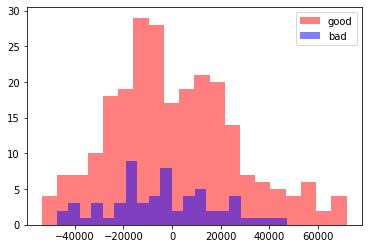

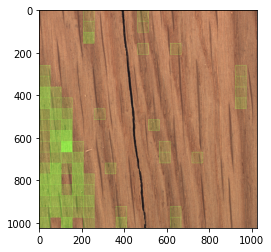

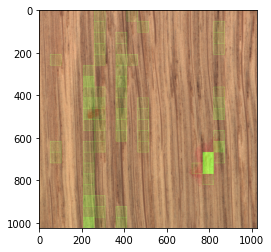

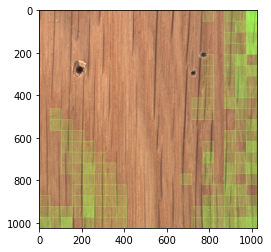

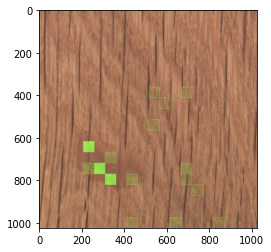

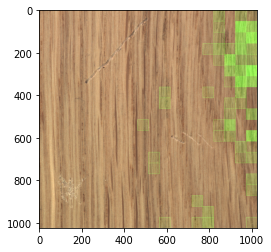

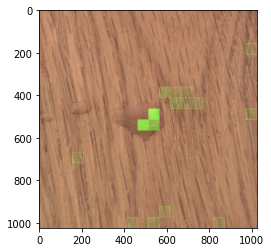

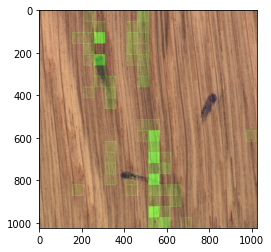

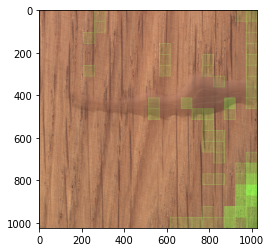

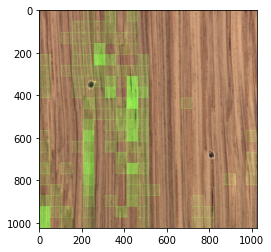

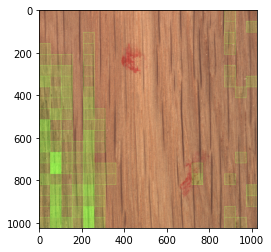

CPU times: user 4.91 s, sys: 389 ms, total: 5.3 s
Wall time: 9.6 s


In [ ]:
%%time
# 推論対象フォルダ
target = "wood"
# hlacのパッチ数
nx, ny = 20, 20

df = create_df(target)
hlacs_good, hlacs_bad = make_hlacs(df, hlac_filters, nx, ny)
# hlacs_good = np.load(BASE_PATH + '/hlac/' + target + '_hlacs_good.npy') # 保存したhlac特徴量を読み込む場合
# hlacs_bad = np.load(BASE_PATH + '/hlac/' + target + '_hlacs_bad.npy') # 保存したhlac特徴量を読み込む場合
hlac_pca = pca(hlacs_good, hlacs_bad)
visualize_roop(df, hlacs_good, hlacs_bad)

## wood 8x8

正解画像


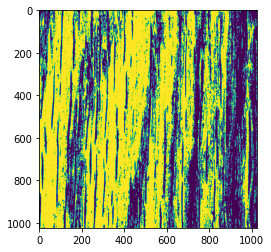

比較画像


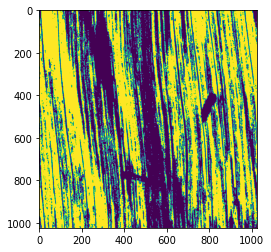

Reference:
 [[ 9595  8457  8393 ...  7903  8148  7467]
 [11642 10578 10519 ...  9952 10187  9498]
 [ 8660  7108  7005 ...  6339  6650  5622]
 ...
 [ 6588  5577  5506 ...  5173  5333  4724]
 [ 9032  7839  7751 ...  7214  7409  6663]
 [ 3392  2525  2442 ...  2142  2302  1834]]

Target:
 [[14081 13657 13639 ... 13517 13568 13181]
 [ 3257  2401  2309 ...  2038  2196  1750]
 [ 7317  6596  6540 ...  6335  6443  5952]
 ...
 [ 5045  3912  3792 ...  3384  3634  2979]
 [10782  9882  9798 ...  9524  9675  8996]
 [ 8256  7227  7078 ...  6676  6926  6173]]

(247, 64, 25)
(60, 64, 25)
(307, 1601)
0    247
1     60
Name: y, dtype: int64
(307, 1)


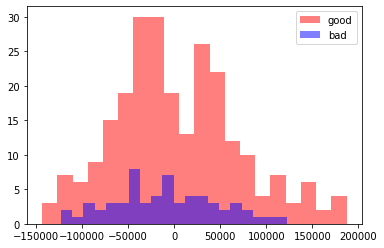

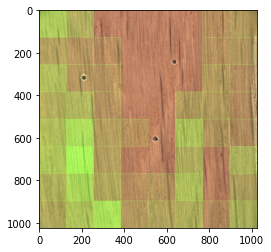

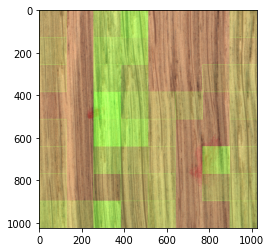

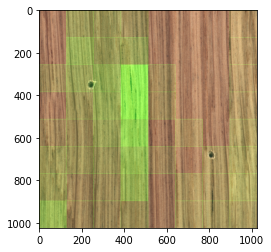

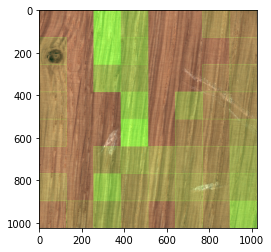

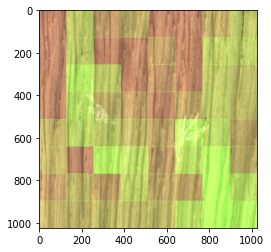

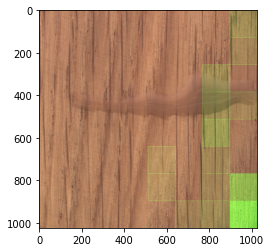

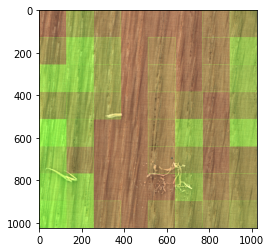

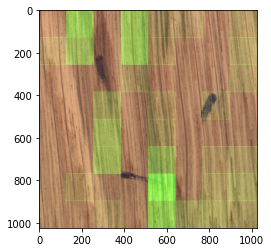

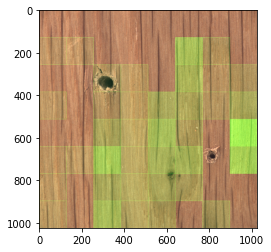

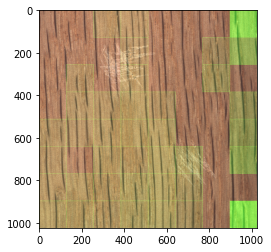

CPU times: user 5min 40s, sys: 14.2 s, total: 5min 54s
Wall time: 5min 54s


In [ ]:
%%time
# 推論対象フォルダ
target = "wood"
# hlacのパッチ数
nx, ny = 8, 8

df = create_df(target)
hlacs_good, hlacs_bad = make_hlacs(df, hlac_filters, nx, ny)
hlac_pca = pca(hlacs_good, hlacs_bad)
visualize_roop(df, hlacs_good, hlacs_bad)

## screw 20x20

正解画像


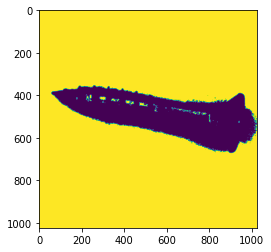

比較画像


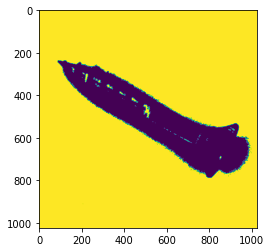

Reference:
 [[2500 2500 2500 ... 2500 2500 2500]
 [2500 2500 2500 ... 2500 2500 2500]
 [2500 2500 2500 ... 2500 2500 2500]
 ...
 [2401 2401 2401 ... 2401 2401 2401]
 [2401 2401 2401 ... 2401 2401 2401]
 [2401 2401 2401 ... 2401 2401 2401]]

Target:
 [[2500 2500 2500 ... 2500 2500 2500]
 [2500 2500 2500 ... 2500 2500 2500]
 [2500 2500 2500 ... 2500 2500 2500]
 ...
 [2401 2401 2401 ... 2401 2401 2401]
 [2401 2401 2401 ... 2401 2401 2401]
 [2401 2401 2401 ... 2401 2401 2401]]

(320, 400, 25)
(119, 400, 25)
(439, 10001)
0    320
1    119
Name: y, dtype: int64
(439, 1)


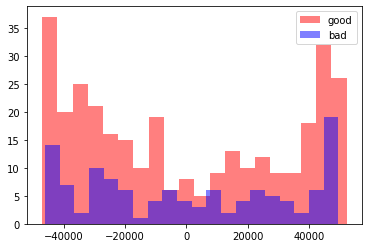

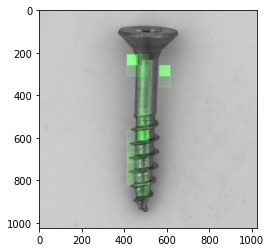

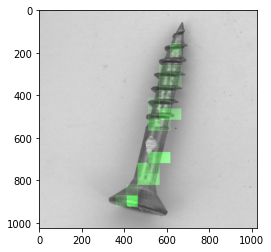

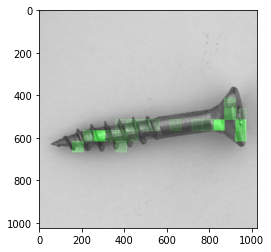

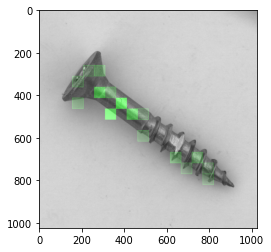

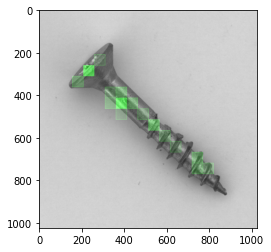

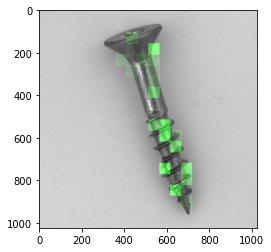

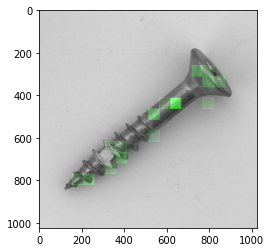

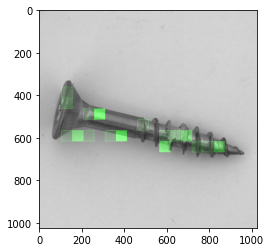

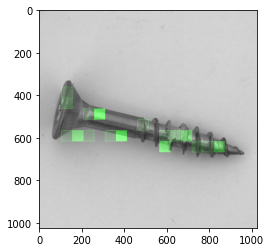

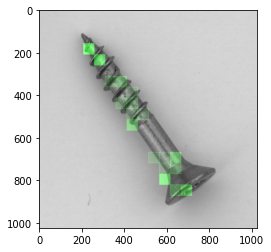

CPU times: user 16min 37s, sys: 2min 1s, total: 18min 38s
Wall time: 17min 20s


In [ ]:
%%time
# 推論対象フォルダ
target = "screw"
# hlacのパッチ数
nx, ny = 20, 20

df = create_df(target)
hlacs_good, hlacs_bad = make_hlacs(df, hlac_filters, nx, ny)
hlac_pca = pca(hlacs_good, hlacs_bad)
visualize_roop(df, hlacs_good, hlacs_bad)

## bottle 20x20

正解画像


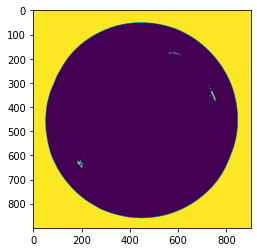

比較画像


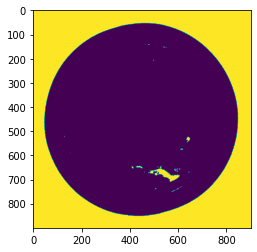

Reference:
 [[1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]
 ...
 [1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]]

Target:
 [[1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]
 ...
 [1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]
 [1849 1849 1849 ... 1849 1849 1849]]

(209, 400, 25)
(63, 400, 25)
(272, 10001)
0    209
1     63
Name: y, dtype: int64
(272, 1)


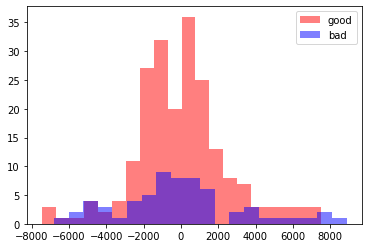

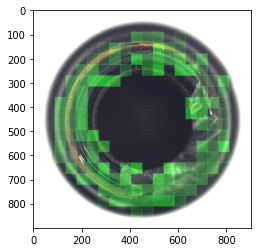

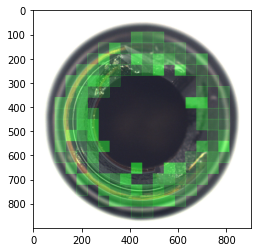

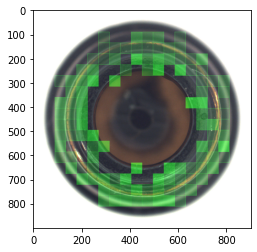

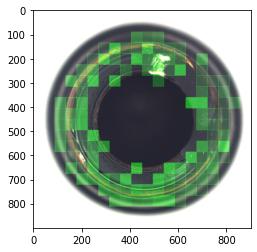

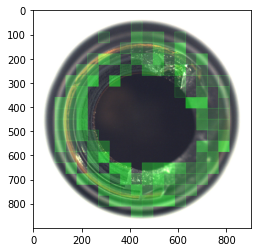

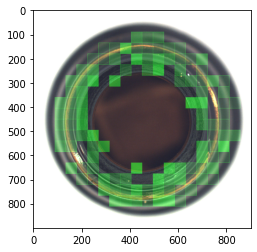

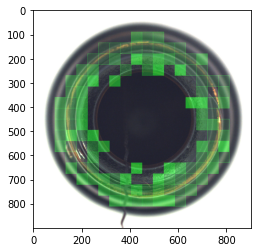

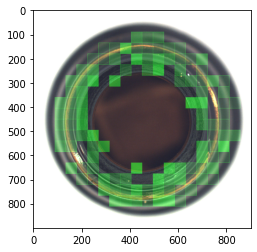

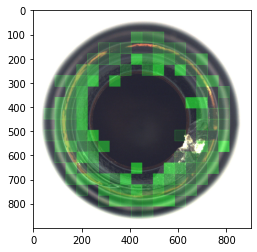

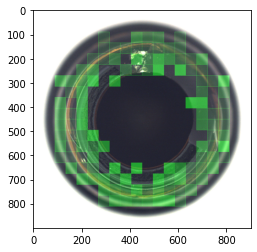

CPU times: user 9min 54s, sys: 1min 5s, total: 11min
Wall time: 10min 35s


In [ ]:
%%time
# 推論対象フォルダ
target = "bottle"
# hlacのパッチ数
nx, ny = 20, 20

df = create_df(target)
hlacs_good, hlacs_bad = make_hlacs(df, hlac_filters, nx, ny)
hlac_pca = pca(hlacs_good, hlacs_bad)
visualize_roop(df, hlacs_good, hlacs_bad)

# 参照

* https://zenn.dev/kotaro_inoue/articles/f0cbbca962313b
* https://zenn.dev/kei1978/articles/3191203ece3a74
